In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

# Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_08023.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_05910.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08151.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0006R0_f01200_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f01110_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f03330_P.png')]

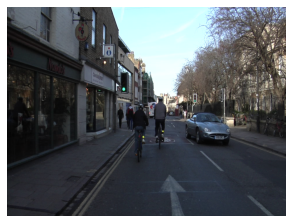

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x:path_lbl/f'{x.stem}_P{x.suffix}'

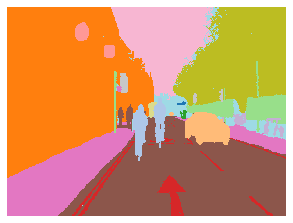

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5),alpha=1)
#Not a usual image file. We are returning only integers. So use open_mask

In [0]:
open_mask?

In [12]:
mask.shape

torch.Size([1, 720, 960])

In [0]:
src_size = np.array(mask.shape[1:])

In [23]:
src_size

array([720, 960])

In [15]:
mask.data

tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
         [ 4,  4,  4,  ..., 26, 26, 26],
         [ 4,  4,  4,  ..., 26, 26, 26],
         ...,
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17]]])

In [16]:
codes = np.loadtxt(path/'codes.txt',dtype= str);codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [17]:
len(codes)

32

# Datasets

In [0]:
# free = gpu_mem_get_free_no_cache()
# free

In [0]:
size = src_size//2
bs = 8

In [0]:
data = (SegmentationItemList.from_folder(path_img)
        #Where to find the data? -> in path_img and its subfolders
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_fn, classes=codes)
        #How to label? -> use the label function on the file name of the data
        .transform(get_transforms(), tfm_y=True, size=size)
        #Data augmentation? -> use tfms with a size of 128, also transform the label images
        .databunch(bs=bs))
 

In [29]:
doc(SegmentationItemList) # For mask segmentation

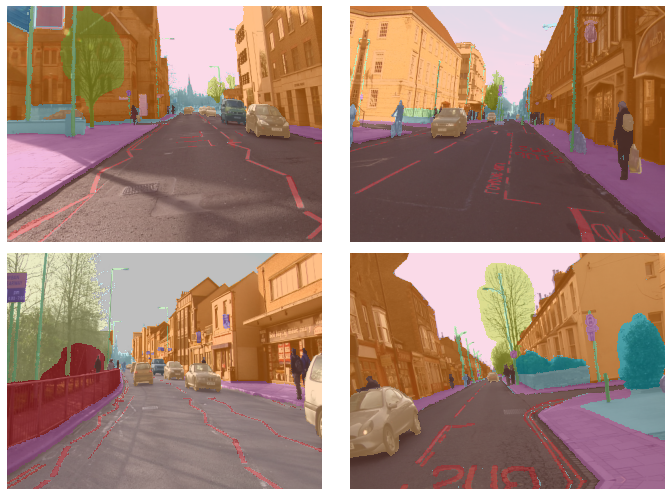

In [30]:
data.show_batch(2,figsize=(10,7))

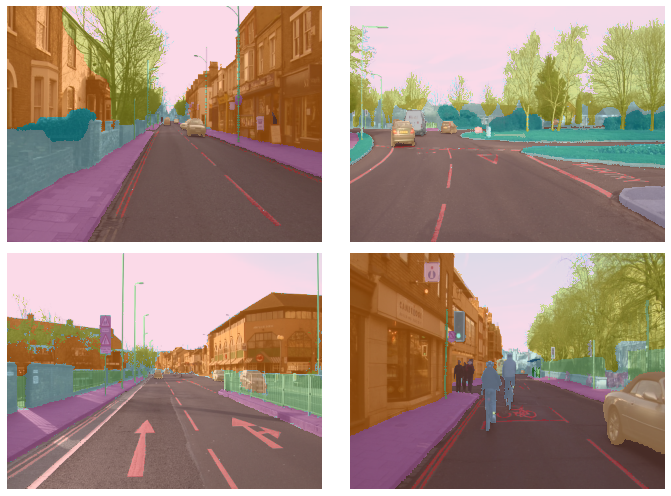

In [31]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

# Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']
# When reporting accuracy one shouldnt report Void
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics = acc_camvid

In [0]:
wd=1e-2

In [35]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [36]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


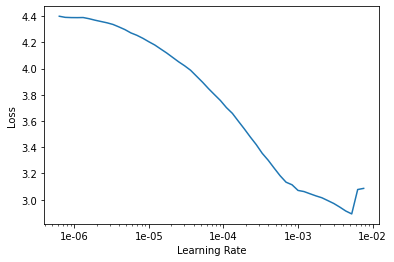

In [37]:
learn.recorder.plot()